In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
GeForce RTX 2080 Ti


In [49]:
!pip3.6 show torch

Name: torch
Version: 1.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/r.astapov/.local/lib/python3.6/site-packages
Requires: numpy, future
Required-by: torchvision


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dataset_dir = "/home/r.astapov/data_set"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir, transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)

In [7]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)

In [8]:
gl_loss = None
gl_acc = None
def save_checkpoint(state, loss, acc, filename='checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    global gl_loss
    global gl_acc
    if (gl_loss is None and gl_acc is None) or (loss < gl_loss and acc > gl_acc):
        gl_loss = loss
        gl_acc = acc
        print (f"=> Saving a new best loss: {loss} acc: {acc}%")
        torch.save(state, filename)
    else:
        print ("=> Validation Loss and Accuracy did not improve")

In [9]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 100):
    losses = []
    accuracies = []
    test_accuracies = []
    test_losses = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc, test_loss = eval_model(model)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'train_accuracy': epoch_acc, 
            'train_loss': epoch_loss,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
        }, test_loss, test_acc)
    print('Finished Training')
    return model, losses, accuracies, test_accuracies, test_losses

In [10]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    running_loss = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    epoch_loss = running_loss/len(trainloader)
    print(f'Accuracy of the network on the test images: {test_acc}% loss: {epoch_loss}')
    return test_acc, epoch_loss

In [11]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [51]:
model = model_ft.cpu()

In [52]:
torch.save({'state_dict': model.state_dict()}, 'checkpoint_new.pth.tar')

In [12]:
model_ft, training_losses, training_accs, test_accs, test_losses = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=50)

Epoch 1, duration: 59 s, loss: 0.5086, acc: 79.8812
Accuracy of the network on the test images: 88.32644628099173% loss: 0.10404589279624056
=> Saving a new best loss: 0.10404589279624056 acc: 88.32644628099173%
Epoch 2, duration: 60 s, loss: 0.1530, acc: 95.0155
Accuracy of the network on the test images: 97.93388429752066% loss: 0.017056398357318574
=> Saving a new best loss: 0.017056398357318574 acc: 97.93388429752066%
Epoch 3, duration: 60 s, loss: 0.0454, acc: 98.5021
Accuracy of the network on the test images: 97.10743801652893% loss: 0.0222022405927539
=> Validation Loss and Accuracy did not improve
Epoch 4, duration: 59 s, loss: 0.0311, acc: 98.9669
Accuracy of the network on the test images: 96.79752066115702% loss: 0.023500189416529996
=> Validation Loss and Accuracy did not improve
Epoch 5, duration: 59 s, loss: 0.0397, acc: 98.6054
Accuracy of the network on the test images: 98.24380165289256% loss: 0.009315896843038577
=> Saving a new best loss: 0.009315896843038577 acc: 9

Accuracy of the network on the test images: 99.58677685950413% loss: 0.0031113888389355895
=> Validation Loss and Accuracy did not improve
Epoch 45, duration: 59 s, loss: 0.0035, acc: 99.8967
Accuracy of the network on the test images: 99.3801652892562% loss: 0.004395594214551509
=> Validation Loss and Accuracy did not improve
Epoch 46, duration: 59 s, loss: 0.0074, acc: 99.7934
Accuracy of the network on the test images: 99.17355371900827% loss: 0.005070857163731534
=> Validation Loss and Accuracy did not improve
Epoch 47, duration: 59 s, loss: 0.0053, acc: 99.8192
Accuracy of the network on the test images: 99.27685950413223% loss: 0.004075105800649367
=> Validation Loss and Accuracy did not improve
Epoch 48, duration: 60 s, loss: 0.0057, acc: 99.8709
Accuracy of the network on the test images: 99.48347107438016% loss: 0.004317079032006412
=> Validation Loss and Accuracy did not improve
Epoch 49, duration: 59 s, loss: 0.0082, acc: 99.8192
Accuracy of the network on the test images: 9

Text(0.5, 1.0, 'Test loss')

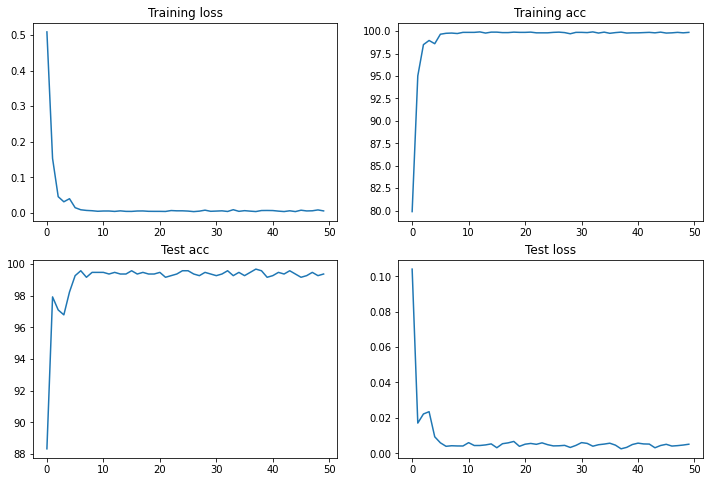

In [13]:
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")
axarr[1, 1].plot(test_losses)

axarr[1, 1].set_title("Test loss")

In [14]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir)

In [15]:
classes

['Hyundai_Solaris_sedan',
 'KIA_Rio_sedan',
 'SKODA_OCTAVIA_sedan',
 'Volkswagen_Polo_sedan',
 'Volkswagen_Tiguan']

In [45]:
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open("sm.4.800.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
# conf, predicted = torch.max(output.data, 1)

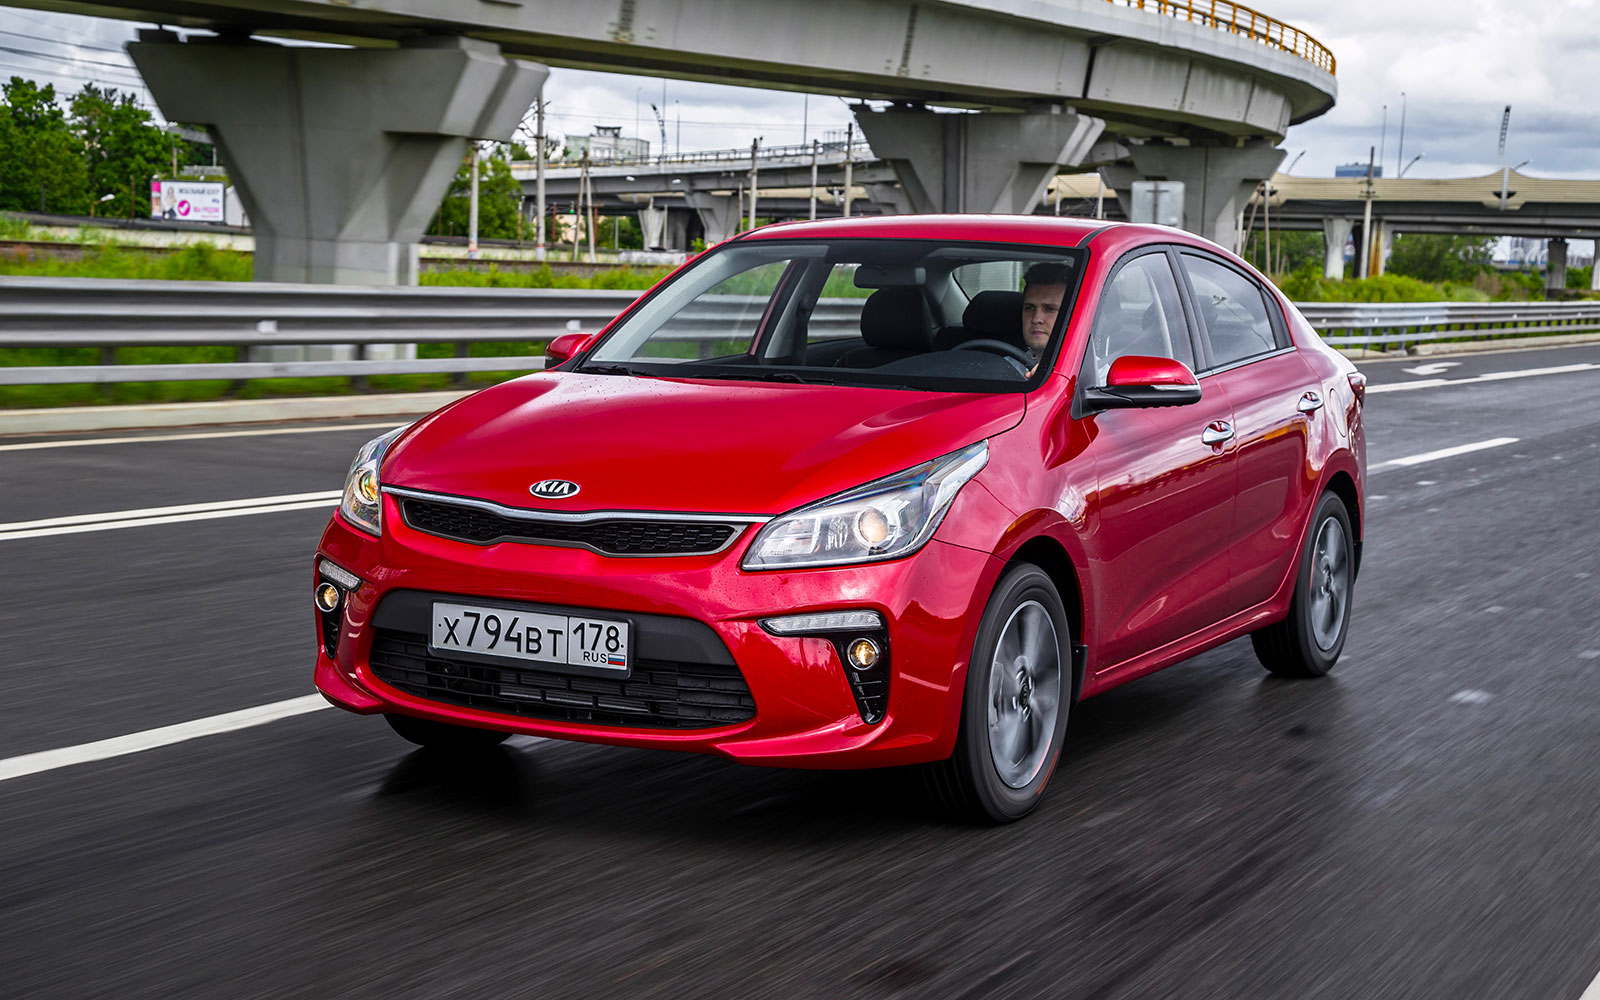

KIA_Rio_sedan confidence:  12.97549057006836


In [35]:
display(Image.open("yaku0021.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())